# Homework #5
## Hierarchical Models and the Theory of Variational Inference

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [4]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#from pymc3 import model_to_graphviz, Model
#import pymc3 as pm
%matplotlib inline

In [19]:
# data_df is the dataframe of your data
# estimates_df is a numpy array of cancer rate estimates, one for each county
def scatter_plot_cancer_rates(data_df, estimates=None):
    ax = data_df.plot(kind='scatter', x="pop",y="pct_mortality", alpha=0.0001, color="grey")
    bot_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=True)[:300]
    top_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=False)[:300]
    top_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.0001, color="blue", ax=ax, logx=True)
    bot_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.0001, color="red", ax=ax, logx=True)
    if estimates is not None:
        ax.plot(data_df['pop'], 5 * estimates, '.', alpha=0.2, color="green")
    ax.set_ylim([-0.0001, 0.0003])

# Problem Description: Understanding EM and Variational Inference

In this problem, we will draw concrete connections between EM and variational inference by applying both methods to a certain class of latent variable models. You'll need to refer to relevant lecture notes on the derivations of EM and the derivation of the variational inference objective. This is an essay question that requires you to engage with complex derivations at a productive but still high level. No implementation is required.

#### Non-Bayesian Latent Variable Model
Recall the class of latent variable models we studied in lecture:
<img src="fig/graphical_model.jpg" style="height:150px;">

#### Bayesian Latent Variable Model
A Bayesian version of the same class of models involve adding priors for the model parameters:
<img src="fig/bayesian_model.jpg" style="height:150px;">

1. **(Comparing ELBOs)** For the above type of Bayesian latent variable model, write down the ELBO for variational inference with a mean field variational family. Compare the variational inference ELBO for the Bayesian model to the expectation maximization ELBO for the non-Bayesian model. What are the differences and similarities between these two ELBOs?

  In both EM and variational inference we optimize the ELBO. Compare the update steps in EM to the update steps in Coordinate Ascent Variational Inference, draw a concrete analogy between them.
  
  ***Hint:*** To make both ELBO's comparable, make sure that both are in terms of $z, y, \theta, \phi$.
  <br><br>
  
2. **(Comparing ELBOs and KL-divergences)** Recall that the original objective of variational inference is to minimize a KL-divergence, we rewrote the objective to be that of maximizing the ELBO. Why is directly minimizing the KL-divergence in the original objective difficult (be specific about wherein the difficulty lies)? 

  In the derivation of the E-step of EM, we reframed an maximization of the ELBO problem as a minimization of a KL-divergence problem. In this case, why was the KL-divergence easier to minimize and the ELBO harder to maximize (use the instantiation of the E-step for Gaussian Mixture Models in Lecture 7 to help support your answer)? 

  In the notes for Lecture 8, we introduce a way to maximize the variational inference ELBO -- through coordinate ascent. In the derivation of the updates for coordinate ascent, there is a place where we reframed an maximization of the ELBO problem as an equivalent minimization of a KL-divergence problem. Write down the exact form of this equivalence (the two expressions are separated in the derivation by a bunch of lines, you'll need to identify both parts that you need). In this case, why was the KL-divergence easier to minimize and the ELBO harder to maximization (use the instantiation of the update for Gaussian Mixture Models in Lecture 8 to help support your answer)?

  Based on this analysis, can you draw some general conclusions about when we'd prefer to minimize the KL-divergence versus when we'd prefer to maximize the ELBO?<br><br>

3. **(The Mean Field Assumption and Coordinate Ascent)**  Describe exactly when and how the mean field assumption is used in the derivation of the coordinate ascent updates. <br><br>

4. **(Generalizability of CAVI)** Summarize what kind of derivations/math is needed in order instantiate Coordinate Ascent Variational Inference (CAVI) for a given new model (look at what we did for Gaussian Mixture Models in Lecture 8 and predict what you'd need to do for a new model). Based on this, discuss the potential draw backs of using CAVI for Bayesian inference in general. Do these draw backs mean that variational inference is not a practical method of inference? What problem(s) need to be solved in order to make variational inference easy to implement for any given Bayesian model?


**Solution:**

### Problem 1: Comparing ELBOs

Recall that the EM ELBO for this type of latent variable model is

$$
ELBO^{\text{EM}}(\theta, \phi, q(z)) = \mathbb{E}_{z\sim q(z)}\left[\log\left(\frac{p(y, z|\theta, \phi)}{q(z)}\right)\right]
$$

whereas the variational inference ELBO for the Bayesian version of this type of  latent variable model is

$$
ELBO^{\text{VI}}(q(\theta|\lambda_2), q(\phi|\lambda_1), q(z|\lambda_3)) = \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)} \left[\log\left(\frac{p(y, z, \theta, \phi|a, b)}{q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}\right)\right]
$$


The simliarity between these two ELBO is that they are both expected log ratios between a joint distribution $p$ and an auxiliary or approximating distribution $q$. In the case of EM, we are measuring the expected (under $q$) log ratio between the auxiliary distribution $q(z)$ and the joint $p(y, z|\theta, \phi)$; in the case of variational inference we are measuring the expected log ratio between the variational distribution $q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)$ and the joint $p(y, z, \theta, \phi|a, b)$. 

The major difference is how the parameters $\theta$ and $\phi$ are treated in the two ELBOs. For EM, we treat $\theta$ and $\phi$ as point masses, in variational inference we treat them as random variables with distributions. In EM, we optimize the ELBO with respect to $\theta$ and $\phi$ as point-masses where as in variational inference we optimize the distribution of $\theta$ and $\phi$. Note that the random variable $z$ plays the same role in both ELBOs.

***For those interested in a deeper connection:*** We can actually prove that EM is a special case of variational inference, by:

1. imposing flat priors for $\theta$ and $\phi$
2. performing variational inference on this model with delta distributions for $q(\theta)$ and $q(\phi)$ 

You'll derive the same ELBO for variational inference as that for the EM estimation of the MLE of $\theta, \phi$.

***Extra Credit is available to any student who fleshes out this argument fully!***

### Problem 2: Comparing ELBOs and KL-divergences


#### Variational Objective
In variational inference, we are interested in finding a tractable distribution $q$ that best approximates a complex distribution $p$. For the latent variable model considered in this problem, the variational objective is

$$
\underset{\lambda}{\min} D_{\text{KL}}[q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3) \| p(\theta, \phi, z|y, a, b)] = \underset{\lambda}{\min} \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)} \left[\log \left( \frac{q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}{p(\theta, \phi, z|y, a, b)}\right) \right]
$$

Recall that the posterior $p(\theta, \phi, z|y, a, b)$ is actually equal to 

$$
p(\theta, \phi, z|y, a, b) = \frac{p(y, z, \theta, \phi| a, b)}{p(y | a, b)} = \frac{p(y, z, \theta, \phi| a, b)}{\int_{\Theta, \Phi, \mathcal{Z}}p(y, z, \theta, \phi| a, b) d(z, \theta, \phi)}
$$

So when we substitue this into the expression of the KL-divergence, we can write:

\begin{aligned}
D_{\text{KL}}[q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3) \| p(\theta, \phi|y, z, a, b)] &= \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)} \left[\log \left( \frac{q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}{p(\theta, \phi, z|y, a, b)}\right) \right]\\
=& \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)} \left[\log \left( \frac{q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)p(y| a, b)}{p(y, z, \theta, \phi| a, b)}\right) \right]\\
=& \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)} \left[\log q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3) + \log p(y | a, b) - \log p(y, z, \theta, \phi| a, b) \right]\\
=& \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)} \left[\log q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)\right] \\
&+ \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}\left[\log p(y | a, b)\right] \\
&- \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}\left[\log p(y, z, \theta, \phi| a, b) \right]\\
\end{aligned}

Note that the second term in the KL-divergence above is hard to compute:

$$
\mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}\left[\log p(y | a, b)\right] = \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}\left[\log \int_{\Theta, \Phi, \mathcal{Z}}p(y, z, \theta, \phi| a, b) d(\theta, \phi, z)\right] 
$$

Now, when we work with the ELBO for variational inference, we have that

\begin{aligned}
ELBO^{\text{VI}}(q(\theta|\lambda_2), q(\phi|\lambda_1), q(z|\lambda_3)) &= \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)} \left[\log\left(\frac{p(y, z, \theta, \phi|a, b)}{q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}\right)\right]\\
&= \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}\left[\log p(y, z, \theta, \phi| a, b) \right] - \mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)} \left[\log q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)\right] 
\end{aligned}

That is, the problemmatic term $\mathbb{E}_{z, \phi, \theta \sim q(z, \phi, \theta |\lambda_1, \lambda_2, \lambda_3)}\left[\log p(y | a, b)\right]$ is gone!

This is why we say that the ELBO is easier to work with than the KL for variational inference.

#### The E-step in EM

In the E-step of EM we had to compute

$$
\underset{q}{\max} ELBO^{\text{EM}}(\theta^*, \phi^*, q(z)) = \underset{q}{\max} \mathbb{E}_{z\sim q(z)}\left[\log\left(\frac{p(y, z|\theta^*, \phi^*)}{q(z)}\right)\right]
$$

where $\theta^*, \phi^*$ are the optimal values we found in the $M$-step.

In order to optimize this ELBO, we needed to take the "gradient" with respect to $q$

$$
\nabla_q \mathbb{E}_{z\sim q(z)}\left[\log\left(\frac{p(y, z|\theta^*, \phi^*)}{q(z)}\right)\right]
$$

But since the expectation is also with respect to $q$, this gradient is hard to compute!

Converting the problem of maximizing the ELBO into one of minimizing a KL-divergence

$$
\underset{q}{\max} ELBO^{\text{EM}}(\theta^*, \phi^*, q(z)) \equiv \underset{q}{\min} D_{\text{KL}}[q(z)\| p(z|y, \theta, \phi) ]
$$

meant that we can solve the optimization problem immediately -- by setting $q(z)$ equal to $p(z|y, \theta, \phi)$. In the case, of the Gaussian Mixture Model, the posterior $p(z|y, \theta, \phi)$ was not difficult to compute. Since the latent variable $z$ is a categorical variable, we could compute the probability of each class membership $z=k$ independently. Each computation was very tractable.

#### The Derivation of the Update for CAVI
Let $\phi = [\phi_1,\ldots, \phi_I]$ be the set of parameters and latent variables for which we want to infer a posterior $p(\phi | y_1, \ldots y_N)$. We approximate this posterior with a mean field variational family:
$$
q(\phi | \lambda) = \prod_{i=1}^I q(\phi_i | \lambda_i)
$$

In CAVI, we update the variational distribution for each $\phi_j$, conditioned on the other $\phi$'s by the rule:
$$
q(\phi_i | \lambda_i) \propto \exp\left\{ \mathbb{E}_{\psi_{-i} \sim q(\phi_{-i} | \lambda^{\text{new}}_{1}, \ldots, \lambda^{\text{new}}_{i-1}, \lambda^{\text{old}}_{i+1}, \ldots, \lambda^{\text{old}}_{I})}\left[\log p(Y_1, \ldots, Y_N, \psi)\right]\right\}
$$

where $\psi_{-i} = [\psi_1\; \ldots\; \psi_{i-1}\; \psi_{i+1}\; \ldots\; \psi_{I}]$.


To prove that this is the update that would maximize the ELBO for the coordinate $i$, we transformed the problem of maximizing the variational inference ELBO with respect to $q(\phi_i | \lambda_i)$ into a problem of minimizing a KL-divergence between $q(\phi_i | \lambda_i)$ and some other distribution:

\begin{aligned}
\underset{\lambda_i}{\max} ELBO(\lambda) &= \underset{\lambda_i}{\max} \int_{\Psi} \left[ \log \left(\frac{p(Y_1, \ldots, Y_N, \psi)}{q(\psi|\lambda)} \right)\right]q(\psi|\lambda) d\psi\\
&= \underset{\lambda_i}{\max} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } {q(\psi_{i}|\lambda_{i})} \right)\right]\\
&\equiv \underset{\lambda_i}{\min} -\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } {q(\psi_{i}|\lambda_{i})} \right)\right]\\
&= \underset{\lambda_i}{\min} \underbrace{\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{ q(\psi_{i}|\lambda_{i}) } {\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } \right)\right]}_{\text{looks like a KL except the denominator is not a distribution}}\quad (\text{using the properties of log})\\
&= \underset{\lambda_i}{\min} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{ \mathcal{Z} q(\psi_{i}|\lambda_{i}) } {\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } \right)\right],\quad (\mathcal{Z} \text{ normalizes the denominator})\\
&= \underset{\lambda_i}{\min} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{  q(\psi_{i}|\lambda_{i}) } {\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } \right)\right] +\log(\mathcal{Z})\\
&\equiv \underset{\lambda_i}{\min}D_{\text{KL}} \left[ q(\psi_{i}|\lambda_{i})\| \mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}\right].
\end{aligned}

The optimization problem involving the KL-divergence was again easy to solve! We just set $q(\psi_{i}|\lambda_{i})$ equal to $\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}$.


So why do we prefer to evalutation this complicated expression $q(\psi_{i}|\lambda_{i})$ equal to $\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}$?

For one, maximizing the ELBO requires taking a gradient with respect to a variable that the expectation depends on: $\nabla_{\lambda_i} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \ldots \right]$. This, again, is a hard problem to sovle.

Secondly, the expectation $\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]$ is not intractible to compute for nice models like Gaussian Mixture Models. Due to the way that these models factorize -- in each update, we end up working with one term involving $\phi_i$, since the other terms involving $\phi_{-i}$ become constants after taking the expectation $\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})}$.


#### When to Work with the ELBO and When to Work with a KL?

The general rule of thumb is intuitive: if the posterior $p(A|B)$ is known and tractible and we have no restrictions on what $q$ needs to be (i.e. it's possible to set $q$ equal to $p$), then minimizing the KL-divergence $D_{\text{KL}}[q(A)\|p(A|B)]$ by setting $q$ equal to $p$ is preferred. If $p(A|B)$ is not known or tractable or when it's not possible to set $q$ exactly equal to $p$, but the joint $p(A, B)$ is tractable then it's preferable to work with the ELBO $\mathbb{E}_{q(A)}\left[\log \frac{p(A, B)}{q(A)}\right]$.



### Problem 3. The Mean Field Assumption and Coordinate Ascent

The mean field assumption allows us to rewrite the expectation in the ELBO over all $\psi_i$'s jointly as iterated expectation:

$$
ELBO(\lambda) = \mathbb{E}_{\psi \sim q(\psi|\lambda)}[\ldots] = \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})}[\ldots] \right]
$$

When we modeled $\psi$'s as independent under the variational distribution $q$, we were able to turn a expectation over multiple variables into an iterated expectiation (over one variable at a time). Note that Fubini's theorem might be able to turn a multiple integral into an iterated integral:

$$
\mathbb{E}_{\psi \sim q(\psi|\lambda)}[\ldots] = \int_{\Psi} [\ldots] q(\psi|\lambda) d\psi = \int_{\Psi_i}\left(\int_{\Psi_{-i}} [\ldots] q(\psi|\lambda) d\psi_{-i} d\right)\psi_i
$$

but we can't express the left-hand integral as an iterated expectation unless we can factorize $q(\psi|\lambda)$:

\begin{align}
\mathbb{E}_{\psi \sim q(\psi|\lambda)}[\ldots] &= \int_{\Psi_i}\left(\int_{\Psi_{-i}} [\ldots] q(\psi|\lambda) d\psi_{-i}\right) d\psi_i\\
&= \int_{\Psi_i}\left(\int_{\Psi_{-i}} [\ldots] q(\psi_{-i}|\lambda_{-i}) d\psi_{-i}\right)q(\psi_i| \lambda_i) d\psi_i\\
&= \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})}[\ldots] \right]
\end{align}

### Problem 4. Generalizability of CAVI

Given a model with a posterior over variable $\psi_1, \ldots, \psi_I$, we'd need to set $q(\psi_{i}|\lambda_{i})$ equal to $\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}$ for every $i$, in order to iteratively maximize the ELBO.

For example, in the Bayesian Gaussain mixture case, we had to derive the update for $q(z|\phi)$ and $q(\mu_k|m_k, s_k^2)$ for each component $k$ in the mixture. Each derivation required an immense amount of algebra. Further more each derivation was different in nature -- for $q(z|\phi)$ we used the fact that $z$ is a categorical variable to compute the probability of $z=k$ individually, for $q(\mu_k|m_k, s_k^2)$ we had to complete the square to make the expression
$$\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}$$ 
look like the pdf of a Gaussian.

This is a process that is highly specialized to the specific model we're given.

One can imagine that if you wanted to implement CAVI for a new model, you'd have to do the entire set of derivations from scratch!

This prevents us from applying variational inference easily to new models and may prevent us from applying variational inference entirely if we are unable to complete these derivations. In order to make variational inference broadly applicable to a large class of Bayesian models we need an automatic and efficient way of 

1. computing the gradient of the ELBO
2. finding the stationary points of this gradient

# Problem Description: Modeling Kidney Cancer Data
In this problem, we will continue to work with the US Kidney Cancer Data set, `kcancer.csv`. This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

**In this homework, we focus on comparing different types of models for this data set.**


## Part I: Empirical Bayes
Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:
\begin{aligned}
y_j | \theta_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

1. **(Visualize the raw cancer rates)** Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. What can you say about the counties with the highest and lowest raw cancer rates.<br><br>

2. **(Empirical Bayes)** Using Empirical Bayes and moment matching, choose values for the hyperparameters $\alpha, \beta$ based on your data. Use these values of $\alpha$ and $\beta$ to obtain posterior distributions for each county.

***Hint:*** You'll first need to derive the fact that the ***evidence*** for a Poisson-Gamma model has a Negative Binomial distribution.<br><br>

3. **(Justification for Empirical Bayes)** Explain why, in this case, it is not a good idea to pick arbitrary values for $\alpha$ and $\beta$ for the gamma prior and proceed with Bayesian inference. Use properties of the cancer dataset to back up your explanation (i.e. it's not *always* problemmatic to choose hyperparameters of the prior arbitrarily, why is it problemmatic for this dataset).<br><br>

4. **(Posterior Means)** Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates vs the county population size, highlight these means in green. 

  Using the scatter plot, explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves.
  
  
**Solutions:**

### Problem #1: Visualize the Raw Cancer Rates

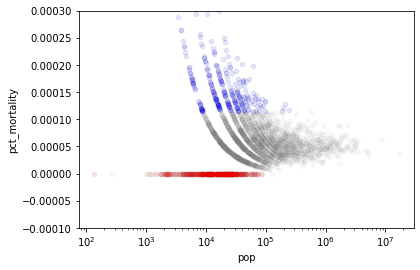

In [6]:
df=pd.read_csv("kcancer.csv")
y = df['dc'].values
n = df['pop'].values

scatter_plot_cancer_rates(df)
plt.show()

It looks like the counties with the highest and lowest raw cancer rates are also the counties with lower populations. This pattern indicates that the raw cancer rates (MLE estimates) may be overfitting to outliers in the data and the cancer rates of counties with fewer people are more exaggerated.

### Problem #2: Empirical Bayes
We note that the Gamma-Poisson model is conjugate, that is, the posterior, posterior predictive and prior predictive all have closed forms. In particular, the posterior distribution is a Gamma distribution and the prior predictive is a Negative Binomial Distribution. Since the Poisson distribution 

\begin{align}
p(\theta_j | y_j) &\propto Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)\\
&\propto e^{-5 \cdot n_j \cdot \theta_j} \left(5 \cdot n_j \cdot \theta_j\right)^{y_j} \theta_j^{\alpha - 1} e^{-\beta\theta_j}\\
&= e^{-\left(5 \cdot n_j \cdot \theta_j + \beta\theta_j\right)} \theta_j^{\alpha + y_j - 1} \left(5 \cdot n_j\right)^{y_j}\\
&\propto e^{-\left(5 \cdot n_j  + \beta\right)\theta_j} \theta_j^{\alpha + y_j - 1}
\end{align}

We see that $p(\theta_j | y_j)$ is a Gamma distribution, $Gamma(\alpha + y_j, 5 n_j  + \beta)$.

Recall that the prior predictive, $p(y_j)$, can computed by
$$
p(y_j) = \frac{p(y_j | \theta_j) p(\theta_j)}{p(\theta_j | y_j)}.
$$
In our case, this becomes

\begin{align}
p(y_j) &= \frac{Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)}{Gamma(\alpha + y_j, 5 n_j  + \beta)}\\
&= \frac{\frac{1}{y_j!} e^{5 \cdot n_j \cdot \theta_j} \frac{\beta^\alpha}{\Gamma(\alpha)} \theta_j^{\alpha - 1} e^{-\beta\theta_j}}{\frac{\left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}}{\Gamma\left(\alpha + y_j\right)} \theta_j^{\alpha + y_j - 1} e^{-\left(5 n_j  + \beta\right) \theta_j}}\\
&= \frac{\beta^\alpha\Gamma\left(\alpha + y_j\right)  \left(5 \cdot n_j\right)^{y_j} \theta_j^{\alpha + y_j - 1}e^{-\left(5 \cdot n_j  + \beta\right)\theta_j}}{y_j!\Gamma(\alpha) \left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}\theta_j^{\alpha + y_j - 1} e^{-\left(5 n_j  + \beta\right) \theta_j}}\\
&= \frac{\beta^\alpha\Gamma\left(\alpha + y_j\right)  \left(5 \cdot n_j\right)^{y_j}}{y_j!\Gamma(\alpha) \left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}}\\
&= \frac{\Gamma\left(\alpha + y_j\right)}{y_j!\Gamma(\alpha)}\frac{\beta^\alpha}{\left(5 n_j  + \beta\right)^{\alpha}} \frac{\left(5 \cdot n_j\right)^{y_j}}{\left(5 n_j  + \beta\right)^{y_j}}\\
&= \frac{\Gamma\left((\alpha + y_j - 1) + 1\right)}{y_j!\Gamma(\alpha)} \left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \frac{(\alpha + y_j - 1)\Gamma\left((\alpha + y_j - 2) - 1\right)}{y_j!\Gamma(\alpha)} \left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\ 
&\vdots\\
&= \frac{(\alpha + y_j - 1)!}{y_j!\Gamma(\alpha)}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \frac{(\alpha + y_j - 1)!}{y_j!(\alpha - 1)!}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \binom{\alpha + y_j - 1}{y_j}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}
\end{align}

In the above, we've used the relation $\Gamma(n + 1) = n\Gamma(n)$ to obtain:

\begin{align}
\Gamma\left(\alpha + y_j\right) &= (\alpha + y_j - 1)!\\
\Gamma(\alpha) &= (\alpha - 1)!
\end{align}


Thus, $p(y_j)$ can be parametrized as $NegBin\left(\alpha, \frac{5 n_j}{1  + \beta}\right)$. From this, we can compute the mean and variance of $y_j$ as 
\begin{align}
\mathbb{E}[y_j] &= \frac{5 n_j \alpha }{\beta}\\
\mathrm{Var}[y_j]&= \frac{(5 n_j)^2\alpha}{\beta^2} + \frac{5 n_j\alpha}{\beta} 
\end{align}

In Type-II MAP methods, typically, we choose a distribution involving the data and the hyperparameters, like the evidence, $p(y_j | \alpha, \beta)$, or the joint distribution of the data and the hyperparameters, $p(y_j, \alpha, \beta)$. We then seek  values of $\alpha$, $\beta$ that maximizes the "likelihood" of the data given by these functions. Note that maximizing $p(y_j | \alpha, \beta)$ and $p(y_j, \alpha, \beta)$ may be difficult (especially when these functions have multiple local optima). Thus, another approach is to estimate $\alpha$ and $\beta$ by performing moment matching. That is, we set the expectation and variance of these distributions to values computed from the data; using these equations we can solve for $\alpha$ and $\beta$. 

Unfortunately, obtaining an valid estimate of $\mathbb{E}[y_j]$ (and $\mathrm{Var}[y_j]$) requires us to have multiple samples of $y_j$, for a fixed $j$, and to average them. Instead, what we have are samples from different $y_j$'s (each from a different distribution). If we are permited to be a bit sloppy, we can treat the set of $y_j$ values are samples from the same distribution. That is, we simply set
\begin{align}
\bar{y}_j = \frac{1}{N}\sum^N_{j=1} y_j &= \mathbb{E}[y_j],\\
sample\_var[y_j]&= \mathrm{Var}[y_j].
\end{align}
If we want to be more precise, we'd want to adjust the number of deaths, $y_j$, in the $j$-th county, by the population of the county. That is, we set
\begin{align}
\overline{\frac{y_j}{n_j}} = \frac{1}{N}\sum^N_{j=1} \frac{y_j}{n_j} &= \frac{5 \alpha }{\beta},\\
sample\_var\left[\frac{y_j}{n_j}\right]= \frac{25\alpha}{\beta^2} + \frac{5\alpha}{n_j\beta} &= \mathbb{E}[y_j] \left( \frac{5}{\beta} + \frac{1}{n_j}\right).
\end{align}
In order to make use of all of our data, we further substitute the empirical mean of the population, $\bar{n}_j$, for $n_j$.

In [7]:
adjusted_y = df['dc'] / df['pop']
y_mean = np.mean(adjusted_y)
y_var = np.var(adjusted_y)
pop_mean = np.mean(df['pop'])

print('empirical cancer population adjusted mean: ', y_mean)
print('empirical cancer population adjusted var: ', y_var)
print('empirical population mean: ', pop_mean)

empirical cancer population adjusted mean:  5.786552354108626e-05
empirical cancer population adjusted var:  2.527523010812238e-09
empirical population mean:  160512.41021522647


Substituting the empirical values into the two equations above, we get:

\begin{align}
\mathtt{5.78655235411e-05}&= \frac{5\alpha }{\beta},\\
\mathtt{2.52752301081e-09}&= \mathtt{5.78655235411e-05}\left(\frac{5}{\beta} + \frac{1}{\mathtt{160512.410215}}\right).
\end{align}

Solving for $\alpha, \beta$, we get
\begin{align}
\alpha &= \frac{\mathtt{5.78655235411e-05}\cdot\beta}{5}\\
\beta &= \frac{5}{\frac{\mathtt{2.52752301081e-09}}{\mathtt{5.78655235411e-05}} - \frac{1}{\mathtt{160512.410215}}}
\end{align}

In [8]:
beta = 5. / (y_var / y_mean - 1. / pop_mean)
alpha = y_mean * beta / 5

print('alpha: ', alpha)
print('beta: ', beta)

alpha:  1.545173491879693
beta:  133514.17193888978


Since we already know the closed form of the posterior distribution, $Gamma(\theta_j; \alpha + y_j, 5 n_j  + \beta)$, we can directly compute the postior mean or posterior mode estimate of $\theta_j$. Or we can sample from $Gamma(\alpha + y_j, 5 n_j  + \beta)$ and compute the mean or mode from the samples:

In [13]:
post_samples = np.array([np.random.gamma(alpha + df['dc'].values, 1. / (beta + 5 * df['pop'].values)) for i in range(5000)])
theta_post_mean = np.mean(post_samples, axis=0)

### Problem #3: Justification for Empirical Bayes
Recall from Lecture #9 that when the number of observations (population count) is low, then the prior can dominate. This means that if we chose some arbitrary prior for the cancer rates $\theta_j$ then for counties with lower population, the posterior over $\theta_j$ may be entirely dominated by the prior (i.e. we are heavily biased by the prior). If we choose the hyperparameters of the prior on $\theta_j$ using the entire set of data, then we allow the data from counties with high population to influence the $\theta_j$ for counties with lower populations through the prior.

### Problem #4: Posterior Means Visualization

We can now plot the posterior mean estimate of the cancer death rate, $\theta_j$ for each county along with the empirical cancer death rate:

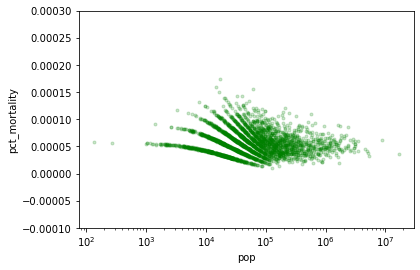

In [20]:
scatter_plot_cancer_rates(df, estimates=theta_post_mean)
plt.show()

We see that the posterior mean estimates of cancer rates for counties with lower populations have shrunk towards the population average. The estimated rates for low-population counties using our Bayesian model are less extreme.

## Part II: Hierarchical Bayes
Rather than choosing fixed constants for the hyperparameters $\alpha, \beta$, following the Bayesian philosophy, we typically put additional priors on quantities of which we are uncertain. That is, we model the kidney cancer rates using a ***hierarchical model***:

\begin{aligned}
y_j| \theta_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j | \alpha, \beta &\sim Ga(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Ga(a, b)\\
\beta &\sim Ga(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 

1.  **(Posterior Marginal Means)** Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the mean of the posterior marginal distribution over $\theta_j$, i.e. $p(\theta_j|y_1, \ldots, y_N)$, vs the county population size, highlight these means in orange. 

  You should use your sampler from the previous homework to obtain these posterior marginal samples.<br><br>


2.  **(Hierarchical Bayes vs Empirical Bayes)** Compare the shrinkage of the posterior marginal means of the hierarchical model to the shrinkage of the posterior means from the Bayesian model with empirical Bayes estimates for $\alpha, \beta$. What is the difference in shrinkage between the full hierarchical model and the Bayesian model with empirical Bayes?


**Solutions:**

### Problem 1: Posterior Marginal Means of the Hierarchical Model

We implement the hierarchical model in `pymc3`!

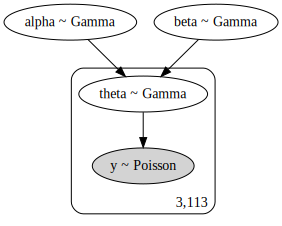

In [8]:
#hyperparameters of hierarchical model
a=9
b=6
c=9
d=0.00001
 
#define hierarchical model in pymc3
with Model() as hiearchical_model:
    #hyperprior on alpha
    alpha = pm.Gamma('alpha', alpha=a, beta=b)
    #hyperprior on beta
    beta = pm.Gamma('beta', alpha=c, beta=d)
    #3,000 priors on theta
    theta = pm.Gamma('theta', alpha=alpha, beta=beta, shape=len(y))
    #convert rate into number of disease incidents
    mu = theta * 5 * n
    #likelihood
    y_obs = pm.Poisson('y', mu=mu, observed=y)
    
#draw graphical model for the thing we just defined  
model_to_graphviz(hiearchical_model)

In [44]:
#sample 1000 samples from the posterior of the hierarchical model
#using 1000 iterations to tune the sampler
#the default sampler for pymc3 is a type of MCMC sampler called No-U-turn HMC, 
#which we have not covered in class
with hiearchical_model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:44<00:00, 90.02draws/s] 
The number of effective samples is smaller than 25% for some parameters.


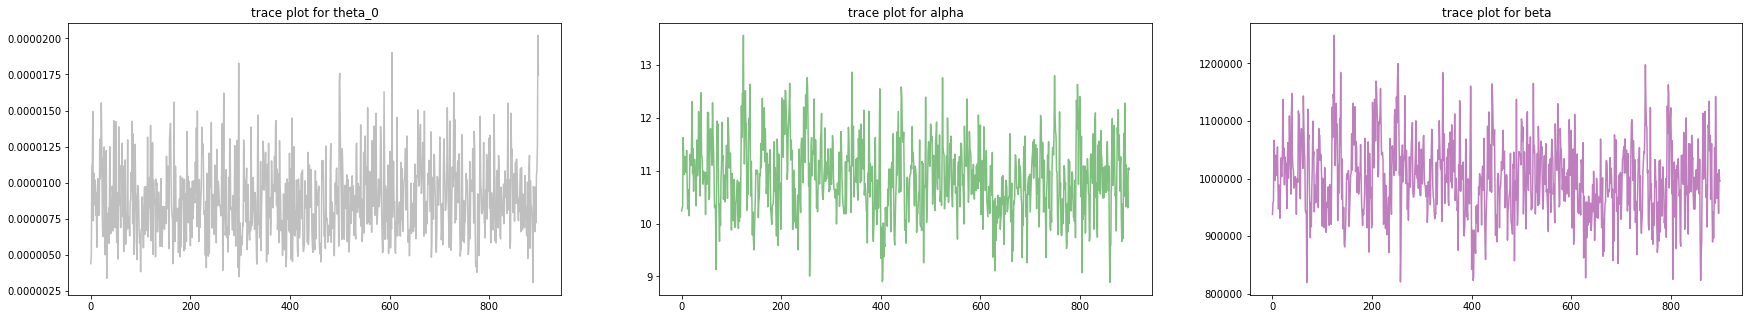

In [45]:
#defined burn-in
burn_in = .1
#define thinning
thin = 2
#select the county to visualize the traceplot for theta
county = 0

#plot the traceplots for one theta and alpha and beta
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
N = len(trace['theta'].T[county])
theta_trace = trace['theta'][int(burn_in * N)::thin].T[county]
ax[0].plot(range(len(theta_trace)), theta_trace, color='gray', alpha=0.5)
ax[0].set_title('trace plot for theta_{}'.format(county))

alpha_trace = trace['alpha'][int(burn_in * N)::thin]
ax[1].plot(range(len(alpha_trace)), alpha_trace, color='green', alpha=0.5)
ax[1].set_title('trace plot for alpha')

beta_trace = trace['beta'][int(burn_in * N)::thin]
ax[2].plot(range(len(beta_trace)), beta_trace, color='purple', alpha=0.5)
ax[2].set_title('trace plot for beta')
plt.show()

It looks like that the chain for the posterior marginal of $\theta_0$ has converged, and the chains for $\alpha$ and $\beta$ looks ok as well. Certainty, the traceplots of $\alpha$ and $\beta$ look much better here than for the naive sampler we implemented last week!

### Problem 2: Hierarchical Bayes vs Empirical Bayes

Ploting the posterior mean estimates of $\theta_j$ from the hierarchical model, we see that the counties with least population shows the most amount of shrinkage! More so that in the case where we did Bayesian modeling with Empirical Bayes estimates of the prior $\theta_j$.

This plot now tells us that the underlying cancer rates inferred from our model are similar across the country (all the rates are around 0.00005%) with some random variations (i.e. some counties have higher rates and others have lower rates), but **this variation is no longer correlated with population size**. 

This model of cancer rates is better aligned with our scientific understanding of biological and environmental causes of cancer. But as some of you noted in class, the extreme shrinkage can disguise true out-liers and anomalies in cancer rates!

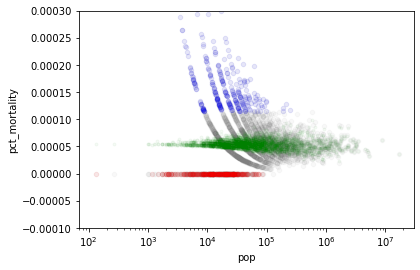

In [43]:
theta_samples = trace['theta'][int(burn_in * N)::thin].T
theta_post_mean_hier = np.mean(theta_samples, axis=1)

scatter_plot_cancer_rates(df, estimates=theta_post_mean_hier)
plt.show()

## Part III: Broader Impact Analysis

Starting in 2020, major machine learning conferences are beginning to ask authors as well as reviewers to explicitly consider the broader impact of new machine learning methods. To properly evaluate the potential good or harm that a piece of technology (AI or not) can do to the general public, we need to be aware that no technology is deployed in ideal conditions or in perfectly neutral contexts. In order to assess the potential broader impact of technology, we need to analyze the social systems/institutions of which these technologies will become a part.

To help you analyze the broader impact of your technology, begin by considering the following questions:

I. Identify the relevant socio-technical systems
  - In what social, political, economic system could the tech be deployed?
  - How would the tech be used in these systems (what role will it take in the decision making processes)?<br><br>
  
II. Identify the stakeholders
  - Who are the users?
  - Who are the affected communities (are these the users)?
  
    ***Hint:*** users are typically decision makers who will use the technology as decision aids (e.g. doctors), whereas affected communities may be folks who are impacted by these decisions but who are not represented in the decision making process (e.g. patients).<br><br>
    
III. What types of harm can this tech do?
  - What kinds of failures can this tech have?
  - What kinds of direct harm can these failures cause?
  - What kinds of harm can the socio-technical system cause?
  
    ***Hint:*** many technical innovations have niche applications, they may sit in a long chain of decision making in a complex system. As such, it may seem, at first glance, that these technologies have no immediate real-life impact. In these cases, it’s helpful to think about the impact of the entire system and then think about how the proposed innovations aid, hamper or change the goals or outcomes of this system.<br><br>
    
IV. What types of good can this tech do?
  - What kinds of needs do these users/communities have?
  - What kinds of constraints do these users/communities have?
  
1. **(Impact)**  Analyze the broader impact of this model for kidney cancer. Focus on anticipating ways these models can interact with other components of the decision systems in which they will be deployed, identifying end-users, affected communities as well as anticipating the effects (positive and negative) on affected communities (in particular, does the model have the same effect on all subpopulations in the affected communities?). 

  In terms of broader impact, is it more preferable to use a hiearchical model, an MLE model or a Bayesian model with hand-picked priors for this dataset? Previously, we have outlined the advantages of hierarchical models over the other two types of models. Under what circumstances would using a hierarchical model to model the data have potentially negative impact on down-stream decision making?
  
**Solutions:** When writing this broader impact statement you should reference our in-class discussion:
1. What are some mathematical drawbacks of MLE vs Bayesian with arbitrary priors vs Hierarchical Bayes? For example, 
  - MLE models can overfit on counties with small populations
  - Arbitrarily chosen priors have disproportionately large impacts on counties with small populations
  - Arbitrarily chosen hyperparameters in Hierarchical Bayes have less impact on your estimate of $\theta_j$
  
2. How do the mathematical drawbacks translate into real-life consequences? For this, you ***need*** to identify the specific human down-stream decisions that could be informed by your model output. For example,
  - Resource allocation for cancer treatment or cancern research funding could be determined based on your estimates of $\theta_j$.
  - Regulatory agencies could be looking for anomalous cancer "hot-spots" in order to uncover areas of high industrial pollution
  
  In these cases, how would underestimating or overestimating the cancer rate translating into negative consequences for real-life people?
  
3. Are the potential failures of our technology at random or systemic? Could the failure modes of our technology exacerbate existing systemic inequities? This is extremely important to consider, because often times the negative consequences stemming from failures of technology are disproportionately felt by already vunerable or marginalized communities (an ML model that randomly rejects student loans will nontheless have the greatest negative effects on low-income students). In this problem, you want to think about:
  - Who are the people living in low population counties? That is, in the US, statistically speaking where are low population counties located? Would these be urban or rural counties? Would these be counties near large  cities or counties located far from large cities? 
  - Would these low population counties contain vunerable or marginalized communities? Again, in the US, given where these counties are located, would they tend to be high-resource, high-income or low-resource, low-income? Another way to think about it, identify known medically vulnerable/marginalized groups in the US, would they be likely to live in low population counties?
  
4. How does our modeling choices affect what we see as the "true" overall trends in the data? Specially, we have touted the benefits of shrinkage: it reduces "overfitting" on low population counties. But exactly what is the definition of "overfitting"? That is, how do we know that an extremely high cancer rate in a low population county must be a sign of overfitting? For example, many of you pointed out that:
  - There are parts of the US where there are abnormally high levels of environmental pollutants (e.g. West Virginia due to mining, Louisiana due to pharmaceutical manufacturing, Flint Michigan due to erosion in lead pipes in the drinking water delivery system, etc). One might expect that abnormally high levels of pollution will lead to abnormally high levels of cancer (see [The Lawyer Who Became DuPont’s Worst Nightmare](https://www.nytimes.com/2016/01/10/magazine/the-lawyer-who-became-duponts-worst-nightmare.html)). 
  - Often times, these levels enviromental pollutant are found in rural areas and disproportionately affect vulnerable and marginalized populations.  